In [1]:
import os

import numpy as np
import pandas as pd

import pcl
import pcl.pcl_visualization
import pythreejs
import pyntcloud
import matplotlib.pyplot as plt

In [26]:
scan = np.fromfile('000009.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile('000009.label', dtype=np.float32)
label = scan.reshape((-1))

cloud_XYZ = pcl.PointCloud()
cloud_XYZ.from_array(scan[:, 0:3])

In [3]:
def voxel_filter(cloud, leaf_sizes):
    """
    Input parameters:
    cloud: input point cloud to be filtered
    leaf_sizes: a list of leaf_size for X, Y, Z 
    Output:
    cloud_voxel_filtered: voxel-filtered cloud
    """
    sor = cloud.make_voxel_grid_filter()
    size_x, size_y, size_z = leaf_sizes
    sor.set_leaf_size(size_x, size_y, size_z)
    cloud_voxel_filtered = sor.filter()
    
    return cloud_voxel_filtered

def roi_filter(cloud, x_roi, y_roi, z_roi):
    """
    Input Parameters:
        cloud: input point cloud
        x_roi: ROI range in X
        y_roi: ROI range in Y
        z_roi: ROI range in Z
    
    Output:    
        ROI region filtered point cloud
    """
    clipper = cloud.make_cropbox()
    cloud_roi_filtered= pcl.PointCloud()
    xc_min, xc_max = x_roi
    yc_min, yc_max = y_roi
    zc_min, zc_max = z_roi
    clipper.set_MinMax(xc_min, yc_min, zc_min, 0, xc_max, yc_max, zc_max, 0)
    cloud_roi_filtered =clipper.filter()
    return cloud_roi_filtered

In [35]:
def draw_point_cloud(cloud, ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        axes_str = ['X', 'Y', 'Z']
        cloud = np.array(cloud) # Covert point cloud to numpy array
        no_points = np.shape(cloud)[0]
        point_size = 10**(3- int(np.log10(no_points))) # Adjust the point size based on the point cloud size
        if np.shape(cloud)[1] == 4: # If point cloud is XYZI format (e.g., I stands for intensity)
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c=cloud[:, 3], cmap='gray')
        elif np.shape(cloud)[1] == 3:   # If point cloud is XYZ format 
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c='b', alpha = 0.7)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
#         if len(axes) > 2: # 3-D plot
#             ax.set_xlim3d(axes_limits[axes[0]])
#             ax.set_ylim3d(axes_limits[axes[1]])
#             ax.set_zlim3d(axes_limits[axes[2]])
#             ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
#         else: # 2-D plot
#             ax.set_xlim(*axes_limits[axes[0]])
#             ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        ax.set_title(title)    
        
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='red'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)
        
def get_cluster_box_list(cluster_indices, cloud_obsts):
    """
    Input parameters:
        cluster_indices: a list of list. Each element list contains the indices of the points that belongs to
                         the same cluster
        colud_obsts: PCL for the obstacles                 
    Output:
        cloud_cluster_list: a list for the PCL clusters: each element is a point cloud of a cluster
        box_coord_list: a list of corrdinates for bounding boxes
    """    
    cloud_cluster_list =[]
    box_coord_list =[]

    for j, indices in enumerate(cluster_indices):
        points = np.zeros((len(indices), 3), dtype=np.float32)
        for i, indice in enumerate(indices):
            
            points[i][0] = cloud_obsts[indice][0]
            points[i][1] = cloud_obsts[indice][1]
            points[i][2] = cloud_obsts[indice][2]
        cloud_cluster = pcl.PointCloud()
        cloud_cluster.from_array(points)
        cloud_cluster_list.append(cloud_cluster)
        x_max, x_min = np.max(points[:, 0]), np.min(points[:, 0])
        y_max, y_min = np.max(points[:, 1]), np.min(points[:, 1])
        z_max, z_min = np.max(points[:, 2]), np.min(points[:, 2])
        box = np.zeros([8, 3])
        box[0, :] =[x_min, y_min, z_min]
        box[1, :] =[x_max, y_min, z_min]
        box[2, :] =[x_max, y_max, z_min]
        box[3, :] =[x_min, y_max, z_min]
        box[4, :] =[x_min, y_min, z_max]
        box[5, :] =[x_max, y_min, z_max]
        box[6, :] =[x_max, y_max, z_max]
        box[7, :] =[x_min, y_max, z_max]
        box = np.transpose(box)
        box_coord_list.append(box)
    return cloud_cluster_list, box_coord_list

In [5]:
cloud_voxel_filtered = voxel_filter(cloud_XYZ, [0.3, 0.3, 0.3])
print('Input cloud size: ', cloud_XYZ.size, ', size after voxel-filtering: ', cloud_voxel_filtered.size)

Input cloud size:  121357 , size after voxel-filtering:  18299


In [6]:
cloud_roi_filtered = roi_filter(cloud_voxel_filtered, [-30, 30], [-6, 8], [-3, 3])
print('Input cloud size: ', cloud_XYZ.size)
print('Size after voxel-filtering: ', cloud_voxel_filtered.size)
print('Size after ROI filter: ', cloud_roi_filtered.size)

Input cloud size:  121357
Size after voxel-filtering:  18299
Size after ROI filter:  5676


In [8]:
scan = scan[:,:3]
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))
test_cloud.plot(backend='pythreejs')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-1.324129343032837, 45.91697978973389, 3.206…

In [10]:
def clustering(cloud, tol, min_size, max_size):
    """
    Input parameters:
        cloud: Input cloud
        tol: tolerance
        min_size: minimal number of points to form a cluster
        max_size: maximal number of points that a cluster allows 
    Output:
        cluster_indices: a list of list. Each element list contains the indices of the points that belongs to
                         the same cluster
    """
    tree = cloud.make_kdtree()
    ec = cloud.make_EuclideanClusterExtraction()
    ec.set_ClusterTolerance(tol)
    ec.set_MinClusterSize(min_size)
    ec.set_MaxClusterSize(max_size)
    ec.set_SearchMethod(tree)
    cluster_indices = ec.Extract()
    return cluster_indices

In [14]:
def plane_segmentation(cloud, dist_thold, max_iter):
    """
    Input parameters:
        cloud: Input cloud
        dist_thold: distance threshold
        max_iter: maximal number of iteration
    Output:
        indices: list of indices of the PCL points that belongs to the plane
        coefficient: the coefficients of the plane-fitting (e.g., [a, b, c, d] for ax + by +cz + d =0)
    """
    seg = cloud.make_segmenter_normals(ksearch=50)# For simplicity,hard coded
    seg.set_optimize_coefficients(True)
    seg.set_model_type(pcl.SACMODEL_NORMAL_PLANE)
    seg.set_method_type(pcl.SAC_RANSAC)
    seg.set_distance_threshold(dist_thold)
    seg.set_max_iterations(max_iter)
    indices, coefficients = seg.segment()
    return indices, coefficients

In [22]:
indices, coefficients = plane_segmentation(cloud_roi_filtered, 0.3, 100)

In [24]:
cloud_obsts = cloud_roi_filtered.extract(indices, negative = True)

In [25]:
%time cluster_indices = clustering(cloud_obsts, 0.7, 30, 400)

CPU times: user 20.4 ms, sys: 33.6 ms, total: 54 ms
Wall time: 55.2 ms


In [27]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [28]:
cloud_obsts

<PointCloud of 1353 points>

In [46]:
def pipeline(scan, indices=None):
    pcloud = pcl.PointCloud()
    pcloud.from_array(scan)
    
    # filter needed segments

    cloud_voxel_filtered = voxel_filter(pcloud, [0.3, 0.3, 0.3])
    cloud_roi_filtered = roi_filter(cloud_voxel_filtered, [-30, 30], [-6, 8], [-3, 3])
    
    if indices == None:
        indices_, coefficients = plane_segmentation(cloud_roi_filtered, 0.3, 100)
        cloud_obsts = cloud_roi_filtered.extract(indices_, negative = True)
    else:
        cloud_obsts = cloud_roi_filtered.extract(indices, negative = True)

    #clustering
    cluster_indices = clustering(cloud_obsts, 0.7, 30, 400)
    
    #get bounding boxes
    cloud_cluster_list, box_coord_list = get_cluster_box_list(cluster_indices, cloud_obsts)

    return cloud_obsts, cloud_cluster_list, box_coord_list

In [47]:
%time cloud_obsts, cloud_cluster_list, box_coord_list = pipeline(scan, None)

CPU times: user 286 ms, sys: 129 ms, total: 414 ms
Wall time: 418 ms


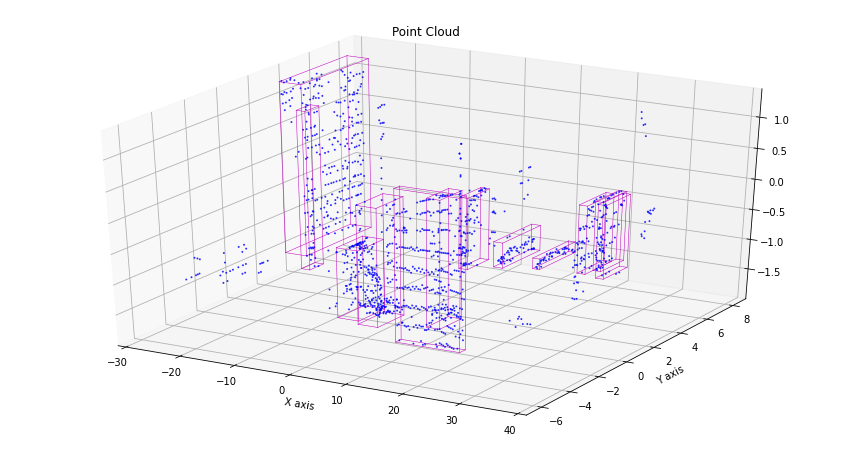

In [48]:
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d') 
draw_point_cloud(cloud_obsts, ax, 'Point Cloud', xlim3d=(-30,40))
for box in box_coord_list:
     draw_box(ax, box, axes=[0, 1, 2], color='m')
plt.show()